In [1]:
!pip install -q "deshima-sensitivity==0.4.0"
#%matplotlib widget
from typing import List, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io, requests
from astropy import units as u
from jupyter_io import savetable_in_notebook
from jupyter_io.output import HTML
# type aliases
ArrayLike = Union[np.ndarray, List[float], List[int], float, int]
# others 
c = 2.99792458e8 #m/s
EL = 60. #deg.

In [2]:
url_Tsys="https://github.com/ishiishun/lst/raw/master/data/Tsys.csv"
s_Tsys=requests.get(url_Tsys).content
df_Tsyss = pd.read_csv(io.StringIO(s_Tsys.decode('utf-8')),
        header=0,
        index_col=0
    )

In [3]:
def PlotTsys():
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    df_Tsyss['Tsys'][84.0:850].plot(ax = ax)
    #x = df_ratio.index
    #ax.plot(x, x/x*np.sqrt(2), "-", linewidth=1,color="b")
    ax.set_xlabel("Frequency (GHz)")
    ax.set_ylabel("System noise temperature, Tsys (K)")
    ax.set_yscale("log")
    #ax.set_xlim(Bands[band]["f_min"], Bands[band]["f_max"])
    ax.set_xlim(84, 850)
    ax.set_ylim(10, np.min([df_Tsyss["Tsys"].max(), 10000.]))
    ax.tick_params(direction="in", which="both")
    ax.grid(True)
    ax.set_title(
        "EL = {} deg".format(EL),
        fontsize=12,
    )
    ax.legend()
    fig.tight_layout()

    # Create download link
    F = df_Tsyss.index
    df_download = pd.DataFrame(data=F, columns=["F(GHz)"])
    df_download["Tsys(K)"] = df_Tsyss['Tsys']

    return savetable_in_notebook(df_download, "Tsys.csv")
    

In [4]:
def LST_HPBW(F: ArrayLike, D = 50.) -> ArrayLike:
    
    wavelength =  c/F
    return 1.21 * wavelength/D

def PlotHPBW_LST():
    """Plot half power beam width of LST.

    Returns
    -------
    html
        HTML object for download link (to be used in Jupyter notebook).

    """
    F = np.arange(84., 850.1, 0.1)*1e9 

    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    ax.plot(
        F / 1e9,
        LST_HPBW(F) * 180 * 60 * 60 / np.pi,
        linewidth=1,
        color="b",
        alpha=1,
        label="D=50 m",
    )

    ax.plot(
        F / 1e9,
        LST_HPBW(F, 30) * 180 * 60 * 60 / np.pi,
        linewidth=1,
        color="g",
        alpha=1,
        label="D=30 m (inner)",
    )


    ax.set_xlabel("Frequency (GHz)")
    ax.set_ylabel("HPBW (arcsec)")
    ax.set_yscale("linear")
    ax.set_xlim(84, 850)
    ax.set_ylim(0, 20)
    ax.tick_params(direction="in", which="both")
    ax.grid(True)
    ax.legend()
    fig.tight_layout()

    # Create download link
    df_download = pd.DataFrame(data=F, columns=["F(GHz)"])
    df_download["HPBW_50m(arcsec)"] = LST_HPBW(F) * 180 * 60 * 60 / np.pi
    df_download["HPBW_30m(arcsec)"] = LST_HPBW(F, 30.) * 180 * 60 * 60 / np.pi

    return savetable_in_notebook(df_download, "HPBW.csv")



In [5]:
def get_dTa_50m(F,                      # frequency, in Hz
            HPBW,                   # HPBW, in arcsec.          
            df_Tsyss,               # Tsys dataframe
            dV,               # velocity resolution in km/s
            N_beam,          # number of beams
            dTa_des,          # desired sensitivity in K
            sample_length = 1./5,   # length of the scan per a sample of integration, in HPBW 
            cell_size = 1./9,       # cell size, in HPBW
            sep_scan = 1./3,        # separation of raster scans, in HPBW
            t_dump = 0.1,           # in sec.
            t_sub_on = 20,          # in sec.
            N_scan = 2,             # number of the raster scans per an OFF scan
            d_OFF = 60.,            # separation between ON and OFF, in arcmin., assuming a 1-deg separation
            n_pol = 2.              # number of pol
           ):
    F = F/1e9
    v = HPBW*sample_length/t_dump   # scan velociy 
    cell = HPBW*cell_size           # cell size (Brogan & Hunter 2014)
    sep_scan = HPBW*sep_scan  
    w_x = v*t_sub_on
    w_y = w_x
    area = w_x*w_y/3600./3600.      # in deg^2
    N_row = np.ceil(w_y/sep_scan)
    t_os = t_sub_on*N_row
    t_tran = 7.
    t_app = 6.
    t_tran_OFF = np.ceil(4.4*d_OFF**(0.26)) 
    t_OH = 2*t_tran_OFF/N_scan + t_app + t_tran*(N_scan-1)/N_scan
    f_cal = 16./15. # R-Sky every 15 min.
    eta = 10.2
    t_sub_off = np.sqrt((t_sub_on + t_OH)* eta*cell*t_sub_on/w_x)*np.sqrt(N_scan)
    t_cell_on = eta*t_sub_on*cell*cell/(w_x*sep_scan)*N_beam*n_pol
    t_cell_off = t_sub_off*cell/sep_scan*N_beam*n_pol
    dfreq = F*dV/(c/1.e3)*1.e9
    dTa = df_Tsyss['Tsys'][F[0]:F[-1]].values*np.sqrt(1/t_cell_on + 1/t_cell_off)/np.sqrt(dfreq)
    Tsys_factor_nro = 1.1*np.exp(-0.18*(1/np.sin(70./180*np.pi)-1/np.sin(EL/180*np.pi)))
    dTa_nro = Tsys_factor_nro*dTa/0.88 #devided by the efficiency of the spectrometer
    t_total = N_row*(t_sub_on + t_OH + t_sub_off/N_scan)*f_cal
    df_dTa = pd.DataFrame(index = F)
    df_dTa.index.name = "F"
    df_dTa["Tsys_50m"] = df_Tsyss['Tsys'][F[0]:F[-1]].values
    df_dTa["HPBW_50m"] = HPBW
    df_dTa["dTa_50m"] = dTa
    df_dTa["t_total_50m"] = t_total/60./60.
    df_dTa["map_size_50m"] = w_x
    df_dTa["area_50m"] = area
    t_total_for_dTa_des_1deg2 = (t_total/60./60.)*np.power(dTa/dTa_des, 2.)/area
    df_dTa["t_total_dTa_des_1deg2_50m"] = t_total_for_dTa_des_1deg2
    return df_dTa, N_beam, t_dump, dTa_des

In [6]:
def get_dTa_30m(F,                      # frequency, in Hz
            HPBW,                   # HPBW, in arcsec.          
            df_Tsyss,               # Tsys dataframe
            dV,               # velocity resolution in km/s
            N_beam,          # number of beams
            dTa_des,          # desired sensitivity in K
            sample_length = 1./5,   # length of the scan per a sample of integration, in HPBW 
            cell_size = 1./9,       # cell size, in HPBW
            sep_scan = 1./3,        # separation of raster scans, in HPBW
            t_dump = 0.1,           # in sec.
            t_sub_on = 20,          # in sec.
            N_scan = 2,             # number of the raster scans per an OFF scan
            d_OFF = 60.,            # separation between ON and OFF, in arcmin., assuming a 1-deg separation
            n_pol = 2.              # number of pol
           ):
    F = F/1e9
    v = HPBW*sample_length/t_dump   # scan velociy 
    cell = HPBW*cell_size           # cell size (Brogan & Hunter 2014)
    sep_scan = HPBW*sep_scan  
    w_x = v*t_sub_on
    w_y = w_x
    area = w_x*w_y/3600./3600.      # in deg^2
    N_row = np.ceil(w_y/sep_scan)
    t_os = t_sub_on*N_row
    t_tran = 7.
    t_app = 6.
    t_tran_OFF = np.ceil(4.4*d_OFF**(0.26)) 
    t_OH = 2*t_tran_OFF/N_scan + t_app + t_tran*(N_scan-1)/N_scan
    f_cal = 16./15. # R-Sky every 15 min.
    eta = 10.2
    t_sub_off = np.sqrt((t_sub_on + t_OH)* eta*cell*t_sub_on/w_x)*np.sqrt(N_scan)
    t_cell_on = eta*t_sub_on*cell*cell/(w_x*sep_scan)*N_beam*n_pol
    t_cell_off = t_sub_off*cell/sep_scan*N_beam*n_pol
    dfreq = F*dV/(c/1.e3)*1.e9
    dTa = df_Tsyss['Tsys'][F[0]:F[-1]].values*np.sqrt(1/t_cell_on + 1/t_cell_off)/np.sqrt(dfreq)
    Tsys_factor_nro = 1.1*np.exp(-0.18*(1/np.sin(70./180*np.pi)-1/np.sin(EL/180*np.pi)))
    dTa_nro = Tsys_factor_nro*dTa/0.88 #devided by the efficiency of the spectrometer
    t_total = N_row*(t_sub_on + t_OH + t_sub_off/N_scan)*f_cal
    df_dTa = pd.DataFrame(index = F)
    df_dTa.index.name = "F"
    df_dTa["Tsys_30m"] = df_Tsyss['Tsys'][F[0]:F[-1]].values
    df_dTa["HPBW_30m"] = HPBW
    df_dTa["dTa_30m"] = dTa
    df_dTa["t_total_30m"] = t_total/60./60.
    df_dTa["map_size_30m"] = w_x
    df_dTa["area_30m"] = area
    t_total_for_dTa_des_1deg2 = (t_total/60./60.)*np.power(dTa/dTa_des, 2.)/area
    df_dTa["t_total_dTa_des_1deg2_30m"] = t_total_for_dTa_des_1deg2
    return df_dTa, N_beam, t_dump, dTa_des

In [7]:
def get_dTa(df_Tsyss, dV, N_beam, dTa_des, D1=50., D2= 30.):
    F = df_Tsyss.index*1.e9
    HPBW_50m = LST_HPBW(F, D=D1) * 180 * 60 * 60 / np.pi
    HPBW_30m = LST_HPBW(F, D=D2) * 180 * 60 * 60 / np.pi
    df_dTa_50m, N_beam_50m, t_dump_50m, dTa_des_50m = get_dTa_50m(F, HPBW_50m, df_Tsyss, dV = dV, N_beam = N_beam, dTa_des = dTa_des)
    df_dTa_30m, N_beam_30m, t_dump_30m, dTa_des_30m = get_dTa_30m(F, HPBW_30m, df_Tsyss, dV = dV, N_beam = N_beam, dTa_des = dTa_des)
    df_dTa = pd.merge(df_dTa_50m, df_dTa_30m, left_index=True, right_index=True)
    
    return df_dTa, N_beam_50m, t_dump_50m, dTa_des_50m

    

In [8]:
def plot_Sensitivity():
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    ax.plot(df_dTa.index, df_dTa["dTa_50m"], label = "LST")
    ax.set_xlabel("Frequency (GHz)")
    ax.set_ylabel("1-sigma sensitivity, dTa* (K)")
    ax.set_ylim(0, 0.4)
    ax.tick_params(direction="in", which="both")
    ax.grid(True)
    ax.set_title(
        "EL = {} deg, N_beam = {}, t_dump = {} sec., Dual polarization".format(EL, int(N_beam), t_dump),
        fontsize=12,
    )
    ax.legend()
    fig.tight_layout()

In [9]:
def PlotSurveySpeed():
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    ax.plot(df_dTa.index, df_dTa["t_total_dTa_des_1deg2_50m"], label = "LST")
    ax.set_xlabel("Frequency (GHz)")
    ax.set_ylabel("Survey speed: time for a 1 deg^2 mapping (hr)")
    ax.set_xlim(80, 400)
    ax.set_ylim(0, 30)
    ax.tick_params(direction="in", which="both")
    ax.grid(True)
    ax.set_title(
        "EL = {} deg, N_beam = {}, dTa_desired = {} K, dV = 0.3 km/s, area = {} deg^2, Dual polarization".format(EL, int(N_beam), dTa_des, 1),
        fontsize=12,
    )
    ax.legend()
    for i in df_lines.index:
        line = i
        freq = df_lines["Frequency"][i]
        if (freq > 80 and 400 > freq):
            ax.axvline(x = freq, color = 'gray', linestyle = "--", label = 'axvline - full height')
            ax.text(freq+1, 15, line, rotation=90, verticalalignment='center')

    fig.tight_layout()
    plt.show()
    

In [10]:
def PlotSurveySpeed2():
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    ax.plot(df_dTa.index, df_dTa["t_total_dTa_des_1deg2_50m"], label = "LST")
    ax.set_xlabel("Frequency (GHz)")
    ax.set_ylabel("Survey speed: time for a 1 deg^2 mapping (hr)")
    ax.set_xlim(350, 500)
    ax.set_ylim(10, 5000)
    ax.set_yscale("log")
    ax.tick_params(direction="in", which="both")
    ax.grid(True)
    ax.set_title(
        "EL = {} deg, N_beam = {}, dTa_desired = {} K, dV = 0.3 km/s, area = {} deg^2, Dual polarization".format(EL, int(N_beam), dTa_des, 1),
        fontsize=12,
    )
    ax.legend()
    for i in df_lines.index:
        line = i
        freq = df_lines["Frequency"][i]
        if (freq > 350 and 500 > freq):
            ax.axvline(x = freq, color = 'gray', linestyle = "--", label = 'axvline - full height')
            ax.text(freq+1, 15, line, rotation=90, verticalalignment='center')

    fig.tight_layout()
    plt.show()

In [11]:
def PlotSurveySpeedHigh():
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))

    ax.plot(df_dTa.index, df_dTa["t_total_dTa_des_1deg2_30m"], label = "LST")
    ax.set_xlabel("Frequency (GHz)")
    ax.set_ylabel("Survey speed: time for a 1 deg^2 mapping (hr)")
    ax.set_xlim(600, 850)
    ax.set_ylim(100, 10000)
    ax.set_yscale('log')
    ax.tick_params(direction="in", which="both")
    ax.grid(True)
    ax.set_title(
        "EL = {} deg, N_beam = {}, dTa_desired = {} K, dV = 0.3 km/s, area = {} deg^2, Dual polarization".format(EL, int(N_beam), dTa_des, 1),
        fontsize=12,
    )
    ax.legend()
    for i in df_lines.index:
        line = i
        freq = df_lines["Frequency"][i]
        if (freq > 650):
            ax.axvline(x = freq, color = 'gray', linestyle = "--", label = 'axvline - full height')
            ax.text(freq+1, 150, line, rotation=90, verticalalignment='center')

    fig.tight_layout()
    plt.show()

In [12]:
def make_df_lines_low(lines, df_dTa):
    df_lines = pd.DataFrame.from_dict(lines, orient='index').rename(columns={0:'Frequency'})
    # df_lines2 = pd.DataFrame.from_dict(lines2, orient='index').rename(columns={0:'Frequency'})
    df2 = pd.DataFrame()
    for i in df_lines.index:
        freq = df_lines["Frequency"][i]
        freq = np.round(freq,1)
        s = df_dTa[freq:freq]
        if (len(s) == 0):
            print("%s at %f is out of frequency coverage due to low atmospheric transmission" % (i, df_lines["Frequency"][i]))
            df_lines.drop(i,axis=0,inplace = True)
        else:
            df2 = df2.append(df_dTa[freq:freq])
    df_lines["HPBW_50m(arcsec)"] = df2["HPBW_50m"].values
    df_lines["HPBW_30m(arcsec)"] = df2["HPBW_30m"].values
    df_lines["Tsys"] = df2["Tsys_50m"].values
    #df_lines["dTa"] = df2["dTa"].values
    #df_lines["t_total"] = df2["t_total"].values
    #df_lines["map_size"] = df2["map_size"].values
    #df_lines["area"] = df2["area"].values
    df_lines["survey_speed_50m(hr)"] = df2["t_total_dTa_des_1deg2_50m"].values
    df_lines["survey_speed_30m(hr)"] = df2["t_total_dTa_des_1deg2_30m"].values
    
    return df_lines

## System noise tempereture

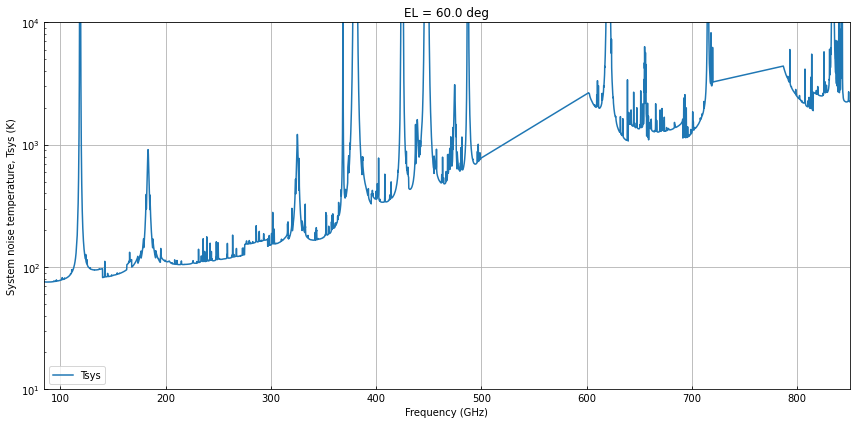

In [13]:
PlotTsys()

##  Angular resolution (HPBW) in arcsec
- blue: HPBW of the full aperture of LST 
- gren: HPBW of the inner 30-m aperture of LST for high-frequency (> 600 GHz) observations

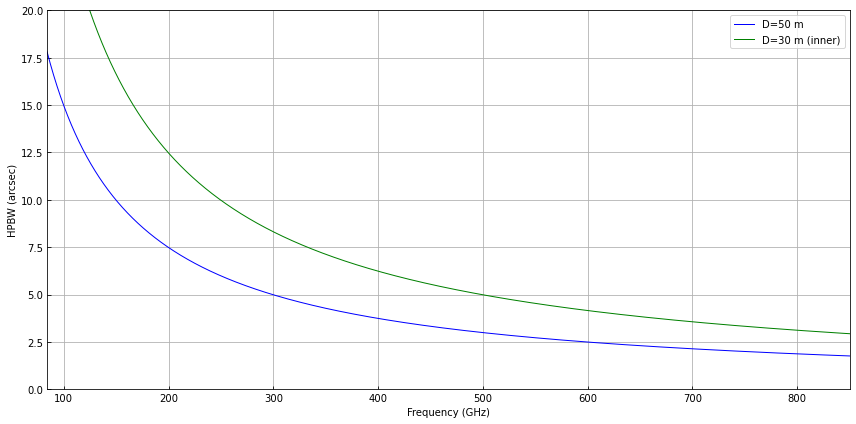

In [14]:
PlotHPBW_LST()

## Parameters for mapping observations with heterodyne receiver array
- Please modify parameters as need for your science cases

In [15]:
dV = 0.3               # velocity resolution in km/s
N_beam = 100.          # number of beams
dTa_des = 0.3          # desired sensitivity in K

## Calculation of the mapping spped: time of a 1 deg^2 area mapping for given parameters

In [16]:
df_dTa, N_beam, t_dump, dTa_des = get_dTa(df_Tsyss, dV = dV, N_beam = N_beam, dTa_des = dTa_des) 

## Emission lines to be plotted and listed 

In [17]:
lines = {
    'CO(1-0)': 115.271,
    'CO(2-1)': 230.538,
    'CO(3-2)': 345.796, 
    'CO(4-3)': 461.04077,
    'CO(6-5)': 691.47308,
    'CO(7-6)': 806.65181,
    '13CO(1-0)': 110.201,
    '13CO(2-1)': 220.399,
    '13CO(3-2)': 330.588,
    '13CO(4-3)': 440.765,
    '13CO(6-5)': 661.067,
    '13CO(7-6)': 771.184,
    'C18O(1-0)': 109.782,
    'C18O(2-1)': 219.56,
    'C18O(3-2)': 329.331,
    'C18O(4-3)': 439.089,
    'C18O(6-5)': 658.553,
    'C18O(7-6)': 768.251,
    'CS(2-1)': 97.980,
    'CS(3-2)': 146.969,
    'CS(4-3)': 195.954,
    'CS(5-4)': 244.953,
    'CS(6-5)': 293.912,
    'CS(7-6)': 342.882,
    'HCN(1-0)': 88.631,
    'HCN(2-1)': 177.261,
    'HCN(3-2)': 265.886,
    'HCN(4-3)': 354.505,
    'HCN(5-4)': 443.116,
    'CI(1-0)': 492.160,
    'CI(2-1)': 809.3
    }

## Checking the list

In [18]:
df_lines = make_df_lines_low(lines, df_dTa)

13CO(7-6) at 771.184000 is out of frequency coverage due to low atmospheric transmission
C18O(7-6) at 768.251000 is out of frequency coverage due to low atmospheric transmission


## Plot of the mapping speed with the lines up to 400 GHz

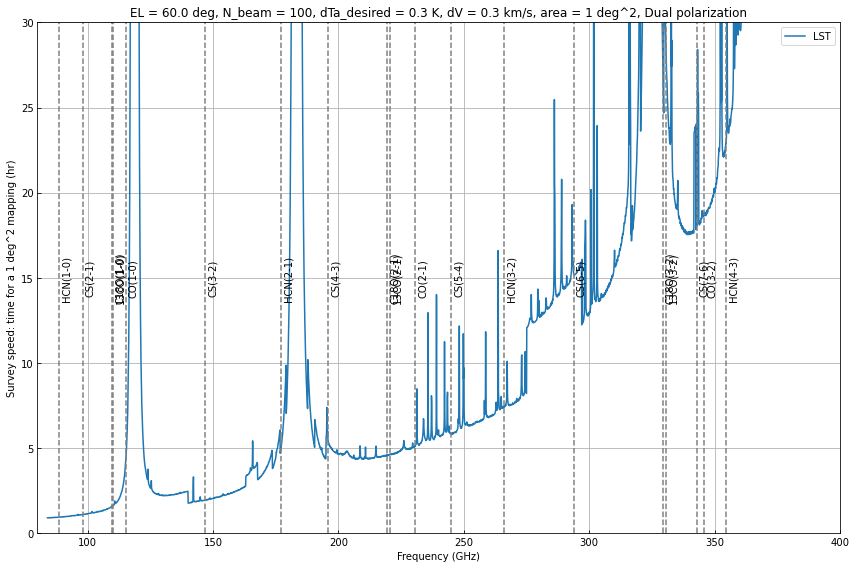

In [19]:
PlotSurveySpeed()

## Plot of the mapping spded with the lines 350 - 500 GHz

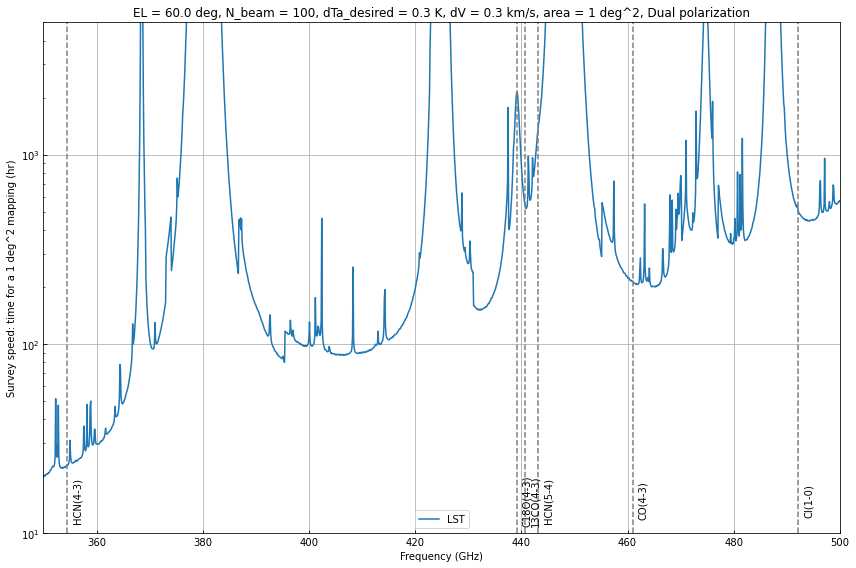

In [20]:
PlotSurveySpeed2()

## Plot of the mapping spped at high-frequency (600 GHz) with the inner 30-m dish

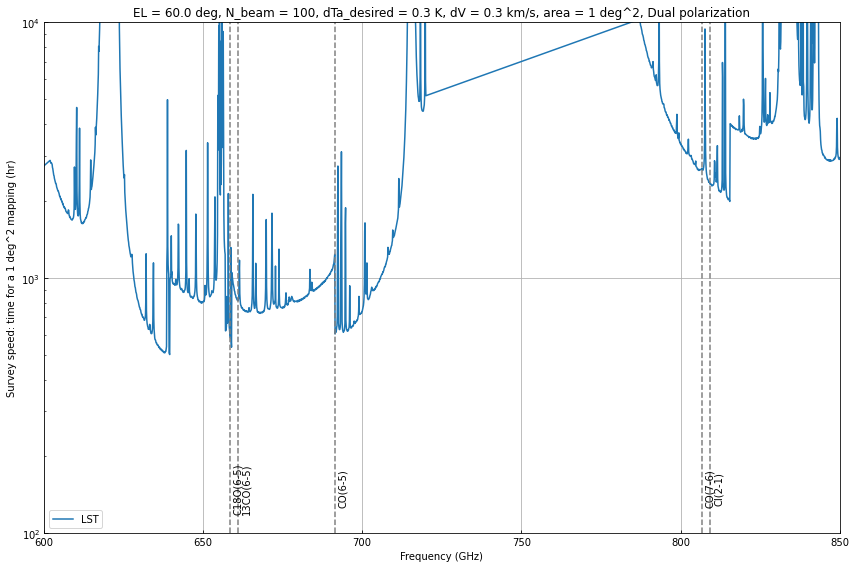

In [21]:
PlotSurveySpeedHigh()

## Show summary 

In [22]:
print(df_lines)
savetable_in_notebook(df_lines, "MappingSpeed.csv")

           Frequency  HPBW_50m(arcsec)  HPBW_30m(arcsec)         Tsys  \
CO(1-0)    115.27100         12.978721         21.631202   142.662293   
CO(2-1)    230.53800          6.492176         10.820293   108.263892   
CO(3-2)    345.79600          4.327491          7.212486   169.631756   
CO(4-3)    461.04077          3.246088          5.410147   495.233847   
CO(6-5)    691.47308          2.164059          3.606764  1135.408918   
CO(7-6)    806.65181          1.855022          3.091704  2208.647361   
13CO(1-0)  110.20100         13.579370         22.632283    88.336470   
13CO(2-1)  220.39900          6.789685         11.316141   105.205086   
13CO(3-2)  330.58800          4.526457          7.544094   213.821335   
13CO(4-3)  440.76500          3.394842          5.658071   795.618552   
13CO(6-5)  661.06700          2.263571          3.772618  1351.932998   
C18O(1-0)  109.78200         13.628839         22.714732    87.425911   
C18O(2-1)  219.56000          6.814420         11.3